### 1

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#------------------------------------------------------
def notch_reject_filter(shape, d0=9, u_k=0, v_k=0):
    P, Q = shape
    # Initialize filter with zeros
    H = np.zeros((P, Q))

    # Traverse through filter
    for u in range(0, P):
        for v in range(0, Q):
            # Get euclidean distance from point D(u,v) to the center
            D_uv = np.sqrt((u - P / 2 + u_k) ** 2 + (v - Q / 2 + v_k) ** 2)
            D_muv = np.sqrt((u - P / 2 - u_k) ** 2 + (v - Q / 2 - v_k) ** 2)

            if D_uv <= d0 or D_muv <= d0:
                H[u, v] = 0.0
            else:
                H[u, v] = 1.0

    return H
#-----------------------------------------------------


img = cv2.imread('1.png', 0)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
phase_spectrumR = np.angle(fshift)
magnitude_spectrum = 20*np.log(np.abs(fshift))

img_shape = img.shape

H1 = notch_reject_filter(img_shape, 8, 26, 26)
H2 = notch_reject_filter(img_shape, 4, -90, 0)
H3 = notch_reject_filter(img_shape, 6, 48, 50)
H4 = notch_reject_filter(img_shape, 4, 60, 0)
H5 = notch_reject_filter(img_shape, 4, -60, 0)
H6 = notch_reject_filter(img_shape, 4, 90, 0)

NotchFilter = H1*H2*H3*H4*H5*H6
NotchRejectCenter = fshift * NotchFilter 
NotchReject = np.fft.ifftshift(NotchRejectCenter)
inverse_NotchReject = np.fft.ifft2(NotchReject)  # Compute the inverse DFT of the result


Result = np.abs(inverse_NotchReject)
plt.figure(figsize=(20,12))
plt.subplot(222)
plt.imshow(img, cmap='gray')
plt.title('Original')

plt.subplot(221)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('magnitude spectrum')

plt.subplot(223)
plt.imshow(magnitude_spectrum*NotchFilter, "gray") 
plt.title("Notch Reject Filter")

plt.subplot(224)
plt.imshow(Result, "gray") 
plt.title("Result")


plt.show()

IndexError: ignored

### 2

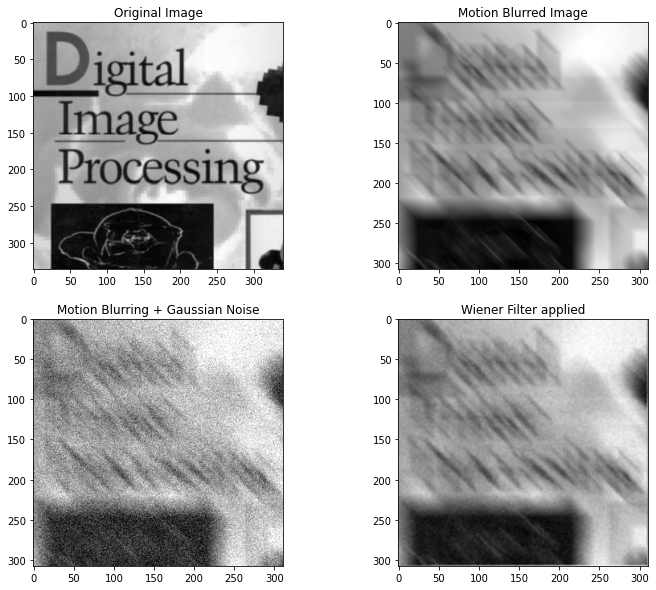

In [ ]:
# April 22, 2019
# Tran Le Anh - MSc Student in Computer Vision
# Dept. of Electronics Engineering, Myongji University, South Korea
# tranleanh.nt@gmail.com
# https://sites.google.com/view/leanhtran

import os
import numpy as np
from numpy.fft import fft2, ifft2
from scipy.signal import gaussian, convolve2d
import matplotlib.pyplot as plt

def blur(img,  mode = 'box', kernel_size = 3):
	dummy = np.copy(img)
	h = np.eye(kernel_size) / kernel_size
	dummy = convolve2d(dummy, h, mode = 'valid')
	return dummy

def add_gaussian_noise(img, sigma):
	gauss = np.random.normal(0, sigma, np.shape(img))
	noisy_img = img + gauss
	noisy_img[noisy_img < 0] = 0
	noisy_img[noisy_img > 255] = 255
	return noisy_img

def wiener_filter(img, kernel, K):
	kernel /= np.sum(kernel)
	dummy = np.copy(img)
	dummy = fft2(dummy)
	kernel = fft2(kernel, s = img.shape)
	kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
	dummy = dummy * kernel
	dummy = np.abs(ifft2(dummy))
	return dummy

def gaussian_kernel(kernel_size):
	h = gaussian(kernel_size, kernel_size / 1).reshape(kernel_size, 1)
	h = np.dot(h, h.transpose())
	h /= np.sum(h)
	return h

def rgb2gray(rgb):
	return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


if __name__ == '__main__':
  # Load image and convert it to gray scale
  img = cv2.imread('w.png',0)
  # img = rgb2gray(plt.imread(file_name))

  # Blur the image
  blurred_img = blur(img, kernel_size = 30)

  # Add Gaussian noise
  noisy_img = add_gaussian_noise(blurred_img, sigma = 650**0.5)

  # Apply Wiener Filter
  noisy_img1 = add_gaussian_noise(blurred_img, sigma = 130**0.5)
  kernel = gaussian_kernel(3)
  filtered_img = wiener_filter(noisy_img1, kernel, K = 15)
  # for i in range(0,5):
  #   filtered_img = wiener_filter(filtered_img, kernel, K = 20)
  # Display results
  display = [img, blurred_img, noisy_img, filtered_img]
  label = ['Original Image', 'Motion Blurred Image', 'Motion Blurring + Gaussian Noise', 'Wiener Filter applied']

  fig = plt.figure(figsize=(12, 10))

  for i in range(len(display)):
    fig.add_subplot(2, 2, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

### 3

(-0.5, 283.5, 379.5, -0.5)

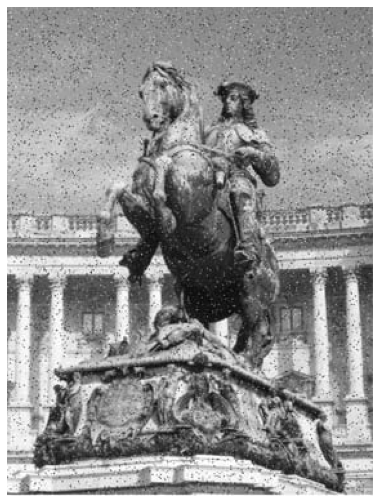

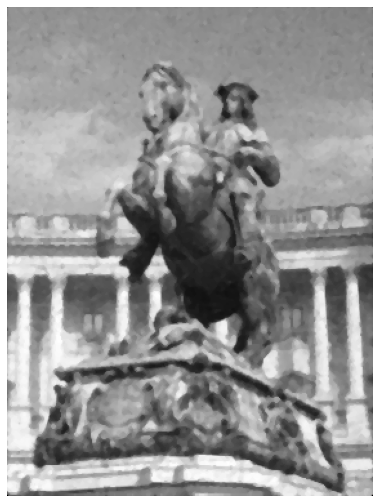

In [ ]:
from scipy import signal
img3 = cv2.imread('3.png',0)
plt.figure(figsize = (16,9))
plt.imshow(img3, cmap='gray')
plt.axis('off')
img_median = signal.medfilt(img3,3)
img_median = signal.medfilt(img_median,3)
img_median = signal.medfilt(img_median,3)
plt.figure(figsize = (16,9))

plt.imshow(img_median, cmap = 'gray', vmin = 0, vmax = np.amax(img_median))
plt.axis('off')


### 4

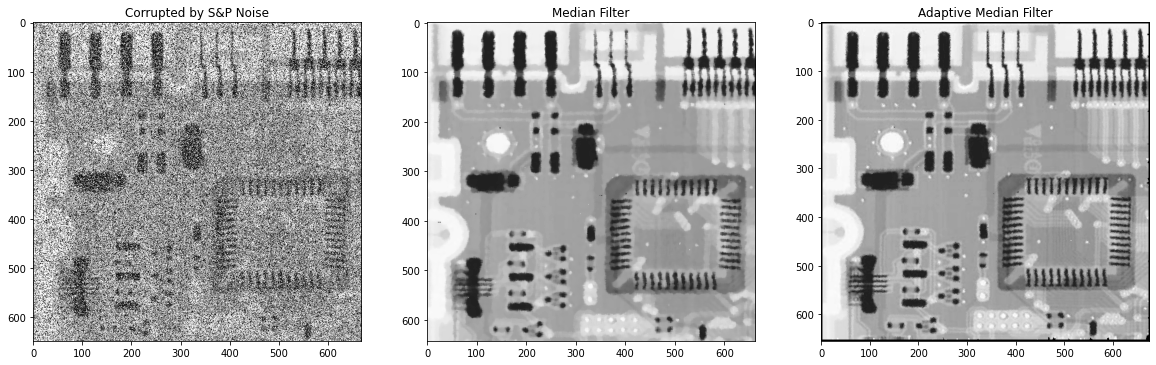

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numba
import numpy as np
from typing import Tuple

from noise import apply_noise
from order_statistic import order_statistic_filter


@numba.njit
def _adaptive_median_filter(mat: np.ndarray, S_max: int):
    M, N = mat.shape
    pad = S_max // 2
    output = np.zeros(mat.shape)

    for i in range(pad, M - pad):
        for j in range(pad, N - pad):
            c_x, c_y = i + pad, j + pad
            wsize = 1
            zxy = mat[c_x, c_y]
            while wsize <= S_max:
                # Step A
                window = mat[c_x - wsize//2:c_x + wsize//2 + 1, c_y - wsize//2:c_y + wsize//2 + 1]
                zmax = np.max(window)
                zmin = np.min(window)
                zmed = np.median(window)
                if zmin < zmed < zmax:
                    # Step B
                    output[i, j] = zxy if zmin < zxy < zmax else zmed
                    break
                else:
                    wsize += 2

            if wsize > S_max:
                output[i, j] = zmed

    return output.astype(np.uint8)

@numba.njit
def _adaptive_lnr_filter(mat: np.ndarray, window_size: Tuple[int, int], noise_var: float = 1.):
    m, n = window_size
    out_height = mat.shape[0] - m + 1
    out_width = mat.shape[1] - n + 1

    output = np.zeros((out_height, out_width))
    for i in range(out_height):
        for j in range(out_width):
            window = mat[i:i + m, j:j + n].astype(np.float64)
            local_var = np.var(window)
            local_mean = np.mean(window)
            gxy = mat[i+m//2+1, j+n//2+1]
            output[i, j] = gxy - noise_var/local_var*(gxy - local_mean)

    return output.astype(np.uint8)


def adaptive_median_filter(mat: np.ndarray, S_max: int):
    assert S_max % 2 == 1
    pad = S_max // 2

    # Force padding for now
    mat = np.pad(
        mat, 
        ((pad, pad),
         (pad, pad)),
        "edge"
    )

    return _adaptive_median_filter(mat, S_max)

def adaptive_lnr_filter(mat: np.ndarray, window_size: Tuple[int, int], 
                        noise_var: float, pad: str = None, order: int = 1) -> np.ndarray:
    assert pad in [None, 'constant', 'edge', 'reflect']

    m, n = window_size
    pad_h, pad_w = (m - 1) // 2, (n - 1) // 2

    for _ in range(order):
        if pad is not None:
            mat = np.pad(
                mat, 
                ((pad_h, pad_h + 1 if m % 2 == 0 else 0),
                 (pad_w, pad_w + 1 if n % 2 == 0 else 0)),
                pad
            )
        mat = _adaptive_lnr_filter(mat, window_size, noise_var)

    return mat


if __name__ == "__main__":
    img = cv2.imread('37b.png', 0)
    # img = cv2.imread('2.png', 0)

    _, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    img_cor = apply_noise(img, 'salt_and_pepper', method='add', ps=0.25, pp=0.25)
    
    axes[0].imshow(img_cor, cmap='gray')
    axes[0].set_title("Corrupted by S&P Noise")

    axes[1].imshow(order_statistic_filter(img_cor, (7, 7), 'median'), cmap='gray')
    axes[1].set_title("Median Filter")
    
    axes[2].imshow(adaptive_median_filter(img_cor, 7), cmap='gray')
    axes[2].set_title("Adaptive Median Filter")

    # plt.savefig("salt.png")

### 5

Text(0.5, 1.0, 'Filter')

<Figure size 1080x1080 with 0 Axes>

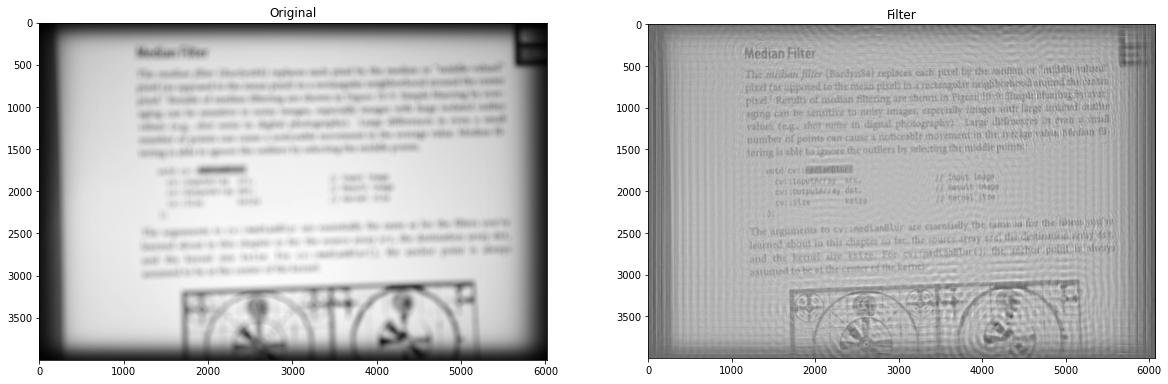

In [ ]:
import cv2 as cv
import numpy as np

def calcPSF(size, R):
    
    h = np.zeros(size, dtype=np.float32)
    cv.circle(h,(size[1]//2,size[0]//2), R, 1, -1)
    psf = h/np.sum(h)
    
    return psf

def calcWnrFilter(psf, SNR):
    
    h_psf = np.fft.fftshift(psf)
    h_planes = [np.float32(h_psf), np.zeros(h_psf.shape, np.float32)]
    h_complexI = cv.merge(h_planes)
    h_complexI = cv.dft(h_complexI)
    h_planes = cv.split(h_complexI)
    denom = np.power(np.abs(h_planes[0]),2) + (1/SNR)
    wiener = np.divide(h_planes[0], denom, dtype = np.float32)

    return wiener

def filter2DFreq(img, wiener):
    
    planes = [np.float32(img), np.zeros(img.shape, np.float32)]
    complexI = cv.merge(planes)
    complexI = np.divide(cv.dft(complexI), complexI.size, dtype = np.float32)
    
    planesH = [np.float32(wiener), np.zeros(wiener.shape, np.float32)]
    complexH = cv.merge(planesH)
    complexIH = cv.mulSpectrums(complexI, complexH, 0)
    
    complexIH = cv.idft(complexIH)
    planes = cv.split(complexIH)
    out = planes[0]
    
    return out

def deBlur(img, R, SNR):
    
    rows, cols = img.shape
    m = cv.getOptimalDFTSize( rows )
    n = cv.getOptimalDFTSize( cols )
    img = (cv.copyMakeBorder(img, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])/255).astype(np.float32)
    
    h = calcPSF((m,n), R)
    Hw = calcWnrFilter(h, SNR)
    out = filter2DFreq(img, Hw)
    
    return out

img = cv.imread("5.jfif",0)

plt.figure(figsize=(15,15))
v = deBlur(img,53,5200)
_, axes = plt.subplots(1, 2, figsize=(20, 10))

axes[0].imshow(img, cmap='gray')
axes[0].set_title("Original")

axes[1].imshow(v, cmap='gray')
axes[1].set_title("Filter")
# plt.imshow(img)
# plt.imshow(v, cmap='gray')